In [1]:
%pwd

u'/Users/firas/Box Sync/Home Folder fsm3/Sync/schmid/data.plus.code/_mcmc_sampler'

In [2]:
from scipy.io import loadmat

import pandas as pd, \
       numpy  as np, \
       matplotlib.pyplot as plt, \
       seaborn as sns
        

%matplotlib inline

###Find index for biomass turnover flux in FBA model 

In [3]:
rxns          = pd.read_csv('../_model_definition/transitionIds.txt',sep='\t',header=None,index_col=None)
rxn_ids       = [x.strip() for x in np.ravel(rxns.values)];
biomass_index = np.where([rxn_ids[x]=='ER90000' for x in range(len(rxn_ids))])[0][0]

### Load wild-type and knock-out sampling results

In [4]:
wt_sampling   = loadmat('../_mcmc_sampler/tp-7/tp-7_wt.mat');
mat_struct    = wt_sampling['sampleStructOut']
val           = mat_struct[0,0]
wt_sampling   = {};

for field in val.dtype.fields.keys():
    if not field[0:2]=='__':
        wt_sampling[field] = val[field];
          
wtSamples = wt_sampling['points'];

/Library/Python/2.7/site-packages/numpy-1.9.2-py2.7-macosx-10.9-intel.egg/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [5]:
ko_sampling   = loadmat('../_mcmc_sampler/tp-7/tp-7_delta_trmb.mat');
mat_struct    = ko_sampling['sampleStructOut']
val           = mat_struct[0,0]
ko_sampling   = {};

for field in val.dtype.fields.keys():
    if not field[0:2]=='__':
        ko_sampling[field] = val[field];
        
koSamples = ko_sampling['points'];

### Perform Singular Value Decomposition on wild-type model 

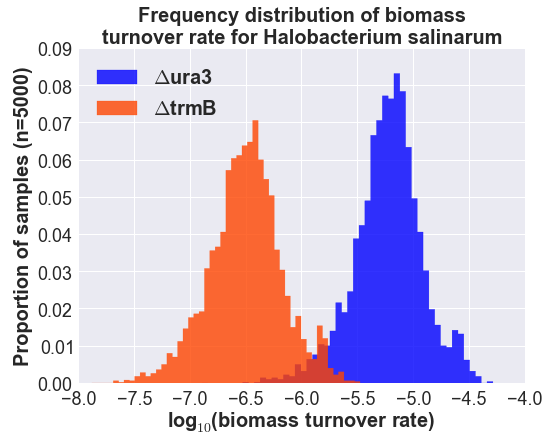

In [6]:
sns.set()

fig = plt.figure(figsize=[8,6])

plt.hist(np.log10(wtSamples[biomass_index,:]),bins=50,color='blue',edgecolor='blue',alpha=0.8,\
         weights=np.zeros_like(wtSamples[biomass_index,:]) + 1. / len(wtSamples[biomass_index,:]),histtype='stepfilled')
plt.hist(np.log10(koSamples[biomass_index,:]),bins=50,color='orangered',edgecolor='orangered',alpha=0.8,\
         weights=np.zeros_like(wtSamples[biomass_index,:]) + 1. / len(wtSamples[biomass_index,:]),histtype='stepfilled')

plt.xlabel(r'log$_{10}$(biomass turnover rate)',fontsize=20,fontweight='bold')
plt.ylabel('Proportion of samples (n=5000)',fontsize=20,fontweight='bold')
#plt.title(r'Frequency distribution of biomass'+'\n'+'turnover rate for $\it{Halobacterium}$ $\it{salinarum}$',\
#          fontsize=20,fontweight='bold')
plt.title(r'Frequency distribution of biomass'+'\n'+'turnover rate for Halobacterium salinarum',\
          fontsize=20,fontweight='bold')


plt.legend([r'$\Delta$ura3','$\Delta$trmB'],loc=2,prop={'size':20,'weight':'bold'})

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig('./biomass.turnover.histogram.pdf', format='pdf', dpi=1000)
plt.show()


In [7]:
wtSamples = wtSamples[0:780];
koSamples = koSamples[0:780];

In [8]:
from scipy.stats.mstats import kruskalwallis
from scipy.stats        import ks_2samp 
h_all=[];
t_all=[];
p_all=[];

for i in range(wtSamples.shape[0]):
    h,p = kruskalwallis(wtSamples[i,2000:],koSamples[i,2000:])
    h_all.append(h);
    #t,p = ks_2samp(wtSamples[i,:],koSamples[i,:])#,equal_var=False)
    #t_all.append(t)
    p_all.append(float(p)/wtSamples.shape[0]);

In [9]:
reversed_fluxes       = pd.read_excel('../_main_scripts/_output/flux_summary_annotated.xlsx', \
                                      sheetname='reversed_reactions',index_col=0,has_index_names=True).fillna('')
reversed_fluxes.index = [reaction.encode('UTF8') for reaction in reversed_fluxes.index]
reversed_fluxes.index

ind_dict = dict((k,i) for i,k in enumerate(rxn_ids)); 
rxns_ind = [ind_dict.get(reaction) for reaction in reversed_fluxes.index]
rxns_ind

[192, 765, 515, 656, 464, 465, 16]

In [10]:

ind_dict = dict((k,i) for i,k in enumerate(rxn_ids)); 
[ind_dict.get(reaction) for reaction in reversed_fluxes.index]

[192, 765, 515, 656, 464, 465, 16]

NameError: name 'sigmas' is not defined

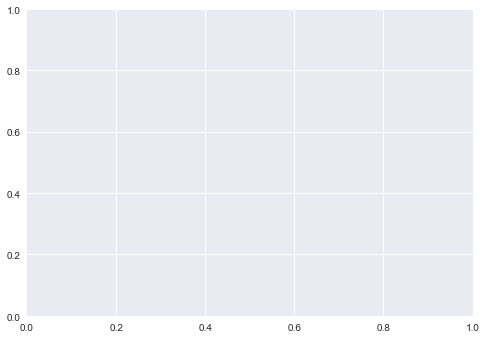

In [11]:
mus1    = pd.DataFrame(wtSamples).apply(np.mean,axis=1)
sigmas1 = pd.DataFrame(wtSamples).apply(np.std,axis=1)

mus2    = pd.DataFrame(koSamples).apply(np.mean,axis=1)
sigmas2 = pd.DataFrame(koSamples).apply(np.std,axis=1)

fig, ax = plt.subplots()

plt.bar(range(len(rxns_ind)),\
        np.log10(abs(mus1[rxns_ind])),\
        width=0.2,color='blue',yerr=np.log10(sigmas[rxns_ind]));

plt.bar([0.2+x for x in range(len(rxns_ind))],\
        np.log10(abs(mus2[rxns_ind])),\
        width=0.2,color='orangered',yerr=np.log10(sigmas1[rxns_ind]));

ax.set_xticklabels(reversed_fluxes.index.values,rotation=40,fontsize=20)

for rr in range(len(rxns_ind)):
    if (mus1[rxns_ind[rr]]>0):
        ax.annotate('+',xy=(0.03+rr,7),fontsize=20)
    else:
        ax.annotate('-',xy=(0.03+rr,7),fontsize=20)
    if (mus2[rxns_ind[rr]]>0):
        ax.annotate('+',xy=(0.25+rr,7),fontsize=20)
    else:
        ax.annotate('-',xy=(0.25+rr,7),fontsize=20)

###Reaction reversals

In [ ]:
reversed_fluxes       = pd.read_excel('../_main_scripts/_output/flux_summary_annotated.xlsx', \
                                      sheetname='reversed_reactions',index_col=0,has_index_names=True).fillna('')
reversed_fluxes.index = [reaction.encode('UTF8') for reaction in reversed_fluxes.index]
reversed_fluxes.index

# ind_dict = dict((k,i) for i,k in enumerate(rxn_ids)); 
# rxns_ind = [ind_dict.get(reaction) for reaction in reversed_fluxes.index]
# rxns_ind = rxns_ind[::-1]

In [ ]:
reversed_fluxes.sort('flux(absolute difference)',ascending=True,inplace=True)

abs_diff_flux = reversed_fluxes.loc[:,'flux(absolute difference)'];

fig = plt.figure()
ax = fig.add_subplot(111)

    
plt.barh([0.2+x  for x in range(abs_diff_flux.shape[0])],np.log10(abs_diff_flux),height=0.6,color='brown')
plt.xlabel('\n'+r'log$_{10}$ absolute change in flux magnitude',fontsize=20)

xmin,xmax = ax.get_xlim()

for rr in range(reversed_fluxes.shape[0]):
    if reversed_fluxes.loc[:,'flux(delta:ura3)'].iloc[rr]<0:
        text_out =  reversed_fluxes.loc[:,'reaction_using_names'].iloc[rr]
    else: 
        text_out = reversed_fluxes.loc[:,'reaction_using_names'].iloc[rr]
        text_out = text_out.split('<=>')[-1]+'<=>'+text_out.split('<=>')[0]
    ax.annotate("  "+text_out.replace('<=>',' ==> '),xy=(xmax,rr+0.45),fontsize=14,fontweight='bold')
    ax.set_yticklabels([])
plt.xticks(fontsize=18)    
plt.title(r'reaction fluxes reversed by $\Delta$trmB knockout',fontsize=20,fontweight='bold')
plt.savefig('../_main_scripts/_output/reversed_fluxes.pdf', format='pdf', dpi=1000)




###Reaction off

In [ ]:
off_fluxes       = pd.read_excel('../_main_scripts/_output/flux_summary_annotated.xlsx', \
                                      sheetname='turned_off_reactions',index_col=0,has_index_names=True).fillna('')
off_fluxes.index = [reaction.encode('UTF8') for reaction in off_fluxes.index]
off_fluxes.index


In [ ]:
off_fluxes.sort('flux(delta:ura3)',ascending=True,inplace=True)

abs_diff_flux = off_fluxes.loc[:,'flux(delta:ura3)'];

fig = plt.figure()
ax = fig.add_subplot(111)

    
plt.barh([0.2+x  for x in range(abs_diff_flux.shape[0])],np.log10(abs_diff_flux),height=0.6,color='brown')
plt.xlabel('\n'+r'log$_{10}$ flux magnitude before knockout of trmB',fontsize=20)

xmin,xmax = ax.get_xlim()

xmin,xmax = ax.get_xlim()

for rr in range(off_fluxes.shape[0]):
    text_out = off_fluxes.loc[:,'name'].iloc[rr]
    if not off_fluxes.loc[:,'name'].iloc[rr]:
        text_out = off_fluxes.loc[:,'reaction_using_names'].iloc[rr]
    ax.annotate("  "+text_out,xy=(xmax,rr+0.45),fontsize=14,fontweight='bold')
    ax.set_yticklabels([])
plt.xticks(fontsize=18)    
plt.title(r'reaction fluxes inactivated by $\Delta$trmB knockout',fontsize=20,fontweight='bold')
plt.savefig('../_main_scripts/_output/inactivated_fluxes.pdf', format='pdf', dpi=1000)





###Reaction on

In [ ]:
on_fluxes       = pd.read_excel('../_main_scripts/_output/flux_summary_annotated.xlsx', \
                                      sheetname='turned_on_reactions',index_col=0,has_index_names=True).fillna('')
on_fluxes.index = [reaction.encode('UTF8') for reaction in on_fluxes.index]
on_fluxes.index, on_fluxes.shape[0]

In [ ]:
on_fluxes.sort('flux(delta:trmb)',ascending=True,inplace=True)

abs_diff_flux = on_fluxes.loc[:,'flux(delta:trmb)'];

fig = plt.figure()
ax = fig.add_subplot(111)

    
plt.barh([0.2+x  for x in range(abs_diff_flux.shape[0])],np.log10(abs_diff_flux),height=0.6,color='brown')
plt.xlabel('\n'+r'log$_{10}$ flux magnitude after knockout of trmB',fontsize=20)

xmin,xmax = ax.get_xlim()

for rr in range(on_fluxes.shape[0]):
    text_out = on_fluxes.loc[:,'name'].iloc[rr]
    ax.annotate("  "+text_out,xy=(xmax,rr+0.45),fontsize=14,fontweight='bold')
    ax.set_yticklabels([])
plt.xticks(fontsize=18)    
plt.title(r'reaction fluxes activated by $\Delta$trmB knockout',fontsize=20,fontweight='bold')
plt.savefig('../_main_scripts/_output/activated_fluxes.pdf', format='pdf', dpi=1000)




###Upregulations

In [ ]:
up_fluxes       = pd.read_excel('../_main_scripts/_output/flux_summary_annotated.xlsx', \
                                      sheetname='upregulated_reactions',index_col=0,has_index_names=True).fillna('')
up_fluxes.index = [reaction.encode('UTF8') for reaction in up_fluxes.index]
up_fluxes.index, up_fluxes.shape[0]
up_fluxes = up_fluxes.iloc[:-1,:]

In [ ]:
up_fluxes.sort('flux(relative difference)',ascending=True,inplace=True)


trmb_flux = up_fluxes.loc[:,'flux(delta:trmb)'];
ura3_flux = up_fluxes.loc[:,'flux(delta:ura3)'];

fig = plt.figure(figsize=[6,15])
ax = fig.add_subplot(111)

    
plt.barh([0.5+2*x  for x in range(ura3_flux.shape[0])],np.log10(ura3_flux),height=0.5,color='brown')
plt.barh([1.0+2*x  for x in range(trmb_flux.shape[0])],np.log10(trmb_flux),height=0.5,color='black')

plt.xlabel('\n'+r'log$_{10}$ flux magnitude',fontsize=20)

xmin,xmax = ax.get_xlim()

for rr in range(up_fluxes.shape[0]):

    text_out = up_fluxes.loc[:,'name'].iloc[rr]
    if not up_fluxes.loc[:,'name'].iloc[rr]:
        text_out = up_fluxes.loc[:,'reaction_using_names'].iloc[rr]
    if rr % 2 == 0:
        ax.annotate("  "+text_out,xy=(xmax,2*rr+0.25),fontsize=14)
    else: 
        ax.annotate("  "+text_out,xy=(xmax,2*rr+0.25),fontsize=14)
    ax.set_yticklabels([])
plt.xticks(fontsize=18)    
plt.title(r'reaction fluxes up-regulated by $\Delta$trmB knockout'+'\n'+'(ordered by relative difference in fluxes)',fontsize=20,fontweight='bold')
plt.ylim([0,2*ura3_flux.shape[0]])
plt.legend([r'$\Delta$trmb',r'$\Delta$ura3'],loc=3,prop={'size':20,'weight':'bold'})
plt.savefig('../_main_scripts/_output/up_regulated_fluxes.pdf', format='pdf', dpi=1000)




###Downregulations

In [ ]:
down_fluxes       = pd.read_excel('../_main_scripts/_output/flux_summary_annotated.xlsx', \
                                      sheetname='downregulated_reactions',index_col=0,has_index_names=True).fillna('')
down_fluxes.index = [reaction.encode('UTF8') for reaction in down_fluxes.index]
down_fluxes.sort('flux(relative difference)',ascending=True,inplace=True)
down_fluxes = down_fluxes.iloc[-51:,:]


In [ ]:

trmb_flux = down_fluxes.loc[:,'flux(delta:trmb)'];
ura3_flux = down_fluxes.loc[:,'flux(delta:ura3)'];

fig = plt.figure(figsize=[6,15])
ax = fig.add_subplot(111)

    
plt.barh([0.5+2*x  for x in range(ura3_flux.shape[0])],np.log10(ura3_flux),height=0.5,color='brown')
plt.barh([1.0+2*x  for x in range(trmb_flux.shape[0])],np.log10(trmb_flux),height=0.5,color='black')

plt.xlabel('\n'+r'log$_{10}$ flux magnitude',fontsize=20)

xmin,xmax = ax.get_xlim()

for rr in range(down_fluxes.shape[0]):#range(down_fluxes.shape[0]):

    text_out = down_fluxes.loc[:,'name'].iloc[rr]
    if not down_fluxes.loc[:,'name'].iloc[rr]:
        text_out = down_fluxes.loc[:,'reaction_using_names'].iloc[rr]
    if rr % 2 == 0:
        ax.annotate("  "+text_out,xy=(xmax,2*rr+0.25),fontsize=14)
    else: 
        ax.annotate("  "+text_out,xy=(xmax,2*rr+0.25),fontsize=14)
    ax.set_yticklabels([])
plt.xticks(fontsize=18)    
plt.title(r'reaction fluxes down-regulated by $\Delta$trmB knockout'+'\n'+'(ordered by relative difference in fluxes)',fontsize=20,fontweight='bold')
plt.ylim([0,2*51])
plt.legend([r'$\Delta$trmb',r'$\Delta$ura3'],loc=3,prop={'size':20,'weight':'bold'})
plt.savefig('../_main_scripts/_output/down_regulated_fluxes.pdf', format='pdf', dpi=1000)


